In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
spark.version

'3.1.1'

In [3]:
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "latest") \
  .option("subscribe", "stock-trades") \
  .load()

In [4]:
stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrade_view") \
    .start()

In [6]:
clear_output(wait=True)
time.sleep(10)

In [7]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM raw_stocktrade_view').show(20))
time.sleep(1)

+----------------+--------------------+------------+---------+------+--------------------+-------------+
|             key|               value|       topic|partition|offset|           timestamp|timestampType|
+----------------+--------------------+------------+---------+------+--------------------+-------------+
|   [5A 42 5A 58]|[7B 22 73 63 68 6...|stock-trades|        0|  2025|2021-06-12 02:31:...|            0|
|      [5A 56 56]|[7B 22 73 63 68 6...|stock-trades|        0|  2026|2021-06-12 02:31:...|            0|
|      [5A 56 56]|[7B 22 73 63 68 6...|stock-trades|        0|  2027|2021-06-12 02:31:...|            0|
|[5A 58 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|        0|  2028|2021-06-12 02:31:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|  2029|2021-06-12 02:31:...|            0|
|[5A 57 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|        0|  2030|2021-06-12 02:31:...|            0|
|[5A 58 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|   

None

In [8]:
time.sleep(1)

In [9]:
raw_stream.stop()

In [10]:
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
    .withColumn("value", stream_df["value"].cast(StringType()))

In [11]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrade_view") \
    .start()

In [12]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM string_stocktrade_view').show(20, False))
time.sleep(1)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------

None

In [13]:
string_stream.stop()

In [14]:
schema_stocktrade = StructType([
    StructField('payload', StructType([
        StructField("side", StringType(),  True),
        StructField("quantity", IntegerType(), True),
        StructField("symbol", StringType(),  True),
        StructField("price", IntegerType(),  True),
        StructField("account", StringType(),  True),
        StructField("userid", StringType(),  True)      
    ]))
])

In [15]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrade))

In [16]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- payload: struct (nullable = true)
 |    |    |-- side: string (nullable = true)
 |    |    |-- quantity: integer (nullable = true)
 |    |    |-- symbol: string (nullable = true)
 |    |    |-- price: integer (nullable = true)
 |    |    |-- account: string (nullable = true)
 |    |    |-- userid: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [17]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_stock_view") \
    .start()

In [18]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_stock_view').show(20))
time.sleep(1)

+-----+--------------------+------------+---------+------+--------------------+-------------+
|  key|               value|       topic|partition|offset|           timestamp|timestampType|
+-----+--------------------+------------+---------+------+--------------------+-------------+
|ZXZZT|{{SELL, 2502, ZXZ...|stock-trades|        0|  2994|2021-06-12 02:32:...|            0|
|ZXZZT|{{SELL, 4226, ZXZ...|stock-trades|        0|  2995|2021-06-12 02:32:...|            0|
|ZJZZT|{{BUY, 1184, ZJZZ...|stock-trades|        0|  2996|2021-06-12 02:32:...|            0|
|ZWZZT|{{SELL, 4325, ZWZ...|stock-trades|        0|  2997|2021-06-12 02:32:...|            0|
|ZJZZT|{{SELL, 4778, ZJZ...|stock-trades|        0|  2998|2021-06-12 02:32:...|            0|
|ZXZZT|{{SELL, 2540, ZXZ...|stock-trades|        0|  2999|2021-06-12 02:32:...|            0|
|  ZVV|{{SELL, 2604, ZVV...|stock-trades|        0|  3000|2021-06-12 02:32:...|            0|
| ZBZX|{{SELL, 3204, ZBZ...|stock-trades|        0|  3001|20

None

In [19]:
json_stream.stop()

In [20]:
stocktrade_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.payload.account", \
        "value.payload.symbol", \
        "value.payload.side", \
        "value.payload.price", \
        "value.payload.quantity", \
        "value.payload.userid"
    )

In [36]:
stocktrade_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- account: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- side: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- userid: string (nullable = true)



In [38]:
stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()

In [46]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrade_view order by event_timestamp desc').show(20))
time.sleep(1)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZTEST|stock-trades|2021-06-12 03:19:...| ABC123| ZTEST|SELL|   11|    4678|User_5|
|      ZVV|stock-trades|2021-06-12 03:19:...| ABC123|   ZVV|SELL|  771|    3507|User_7|
|     ZBZX|stock-trades|2021-06-12 03:19:...| LMN456|  ZBZX| BUY|  351|      54|User_7|
|    ZWZZT|stock-trades|2021-06-12 03:19:...| XYZ789| ZWZZT| BUY|  400|    1802|User_1|
|    ZTEST|stock-trades|2021-06-12 03:19:...| XYZ789| ZTEST|SELL|  718|    1091|User_4|
|    ZVZZT|stock-trades|2021-06-12 03:19:...| LMN456| ZVZZT|SELL|  630|     415|User_7|
|      ZVV|stock-trades|2021-06-12 03:19:...| XYZ789|   ZVV|SELL|  523|    2091|User_2|
|    ZXZZT|stock-trades|2021-06-12 03:19:...| LMN456| ZXZZT|SELL|  501|    3707|User_8|
|      ZVV|stock-trades|2021-06-

None

In [51]:
clear_output(wait=True)
display(spark.sql('SELECT event_key, COUNT(1) AS count, round(mean(price),0) as price, round(mean(quantity),0) as qty FROM stocktrade_view GROUP BY 1').show(20))
time.sleep(1)

+---------+-----+-----+------+
|event_key|count|price|   qty|
+---------+-----+-----+------+
|    ZXZZT|  809|506.0|2477.0|
|    ZVZZT|  781|509.0|2526.0|
|    ZTEST|  801|501.0|2547.0|
|    ZWZZT|  785|489.0|2511.0|
|    ZJZZT|  778|496.0|2550.0|
|      ZVV|  761|497.0|2537.0|
|     ZBZX|  727|504.0|2481.0|
+---------+-----+-----+------+



None

In [50]:
stocktrade_stream.stop()

In [26]:
window_duration = '60 seconds'
slide_duration = '10 seconds'

In [27]:
windowed_count_df = stocktrade_stream_df \
    .withWatermark("event_timestamp", "1 minutes") \
    .groupBy(F.window(stocktrade_stream_df.event_timestamp, window_duration, slide_duration), stocktrade_stream_df.symbol) \
    .count()

In [28]:
count_stream = windowed_count_df \
    .writeStream \
    .format("memory") \
    .outputMode("Complete") \
    .queryName("count_view") \
    .start()

In [29]:
while True:
    clear_output(wait=True)
    display(spark.sql('SELECT * FROM count_view LIMIT 20').show())
    time.sleep(1)

+--------------------+------+-----+
|              window|symbol|count|
+--------------------+------+-----+
|{2021-06-12 02:33...|  ZBZX|   76|
|{2021-06-12 02:32...|   ZVV|   63|
|{2021-06-12 02:33...| ZTEST|  162|
|{2021-06-12 02:32...|   ZVV|    7|
|{2021-06-12 02:32...| ZXZZT|   84|
|{2021-06-12 02:32...| ZVZZT|   79|
|{2021-06-12 02:33...| ZWZZT|  119|
|{2021-06-12 02:32...| ZVZZT|  107|
|{2021-06-12 02:32...|  ZBZX|   91|
|{2021-06-12 02:32...|  ZBZX|  119|
|{2021-06-12 02:33...| ZVZZT|  130|
|{2021-06-12 02:32...| ZTEST|  129|
|{2021-06-12 02:33...|   ZVV|   81|
|{2021-06-12 02:33...| ZTEST|  163|
|{2021-06-12 02:34...|   ZVV|   22|
|{2021-06-12 02:32...| ZWZZT|   47|
|{2021-06-12 02:33...| ZTEST|  112|
|{2021-06-12 02:32...| ZJZZT|   83|
|{2021-06-12 02:33...| ZJZZT|  167|
|{2021-06-12 02:32...| ZVZZT|   51|
+--------------------+------+-----+



None

KeyboardInterrupt: 

In [67]:
# count_stream.stop()

In [145]:
########################
# Visualisations
########################
# Graphing real-time data
# loading packages
import time
import random as rd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt


# sample data from stocktrade_view
#x_y = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 2000''')
#x_y_df = x_y.toPandas()
#x_y_df

In [146]:
# The following routine displays 3 graphs which include 1 scatter plot, 1 line graph and 1 column chart) 
def bunchofplots(x1, y1, title1, x2, data2, labels2, title2, x3, y3, title3):
    clear_output(wait=True)
    # Placing the plots in the plane
    fig = plt.figure(figsize = (15,10))
    plot1 = plt.subplot2grid((4, 9), (0, 0), rowspan=2, colspan=3)
    plot2 = plt.subplot2grid((4, 9), (0, 4), rowspan=4, colspan=5)
    plot3 = plt.subplot2grid((4, 9), (2, 0), rowspan=2, colspan=3)
  
    # Using numpy to create an array x
    x = [x for x in range(0,11)]

    
    # scatter plot
    plot1.scatter(x1, y1, color='k') # black dots
    m, b = np.polyfit(x1, y1, 1)
    plot1.plot(x1, [x * m for x in x1] + b) # showing the line of best-fit
    plot1.set(xlabel = 'Price', ylabel = 'Quantity')
    plot1.set_title(title1)

    
    # column chart
    plot2.bar(x2 + 0.00, data2[0], color = 'g', width = 0.25)
    plot2.bar(x2 + 0.25, data2[1], color = 'r', width = 0.25)
    plot2.legend(labels=['BUY', 'SELL'])
    plot2.set_xticks(x2)
    plot2.set_xticklabels(labels2)

    plot2.set_title(title2)
    plot2.grid(True)
    plot2.set(xlabel = 'Stock symbol', ylabel = 'Traded amount in $')

    
    # line graph
    plot3.plot(x3, y3, color='r') 
    plot3.set_title(title3)
    plot3.set(xlabel = 'Time', ylabel = 'Price')

    # Packing all the plots and displaying them
    plt.tight_layout()
    plt.show()

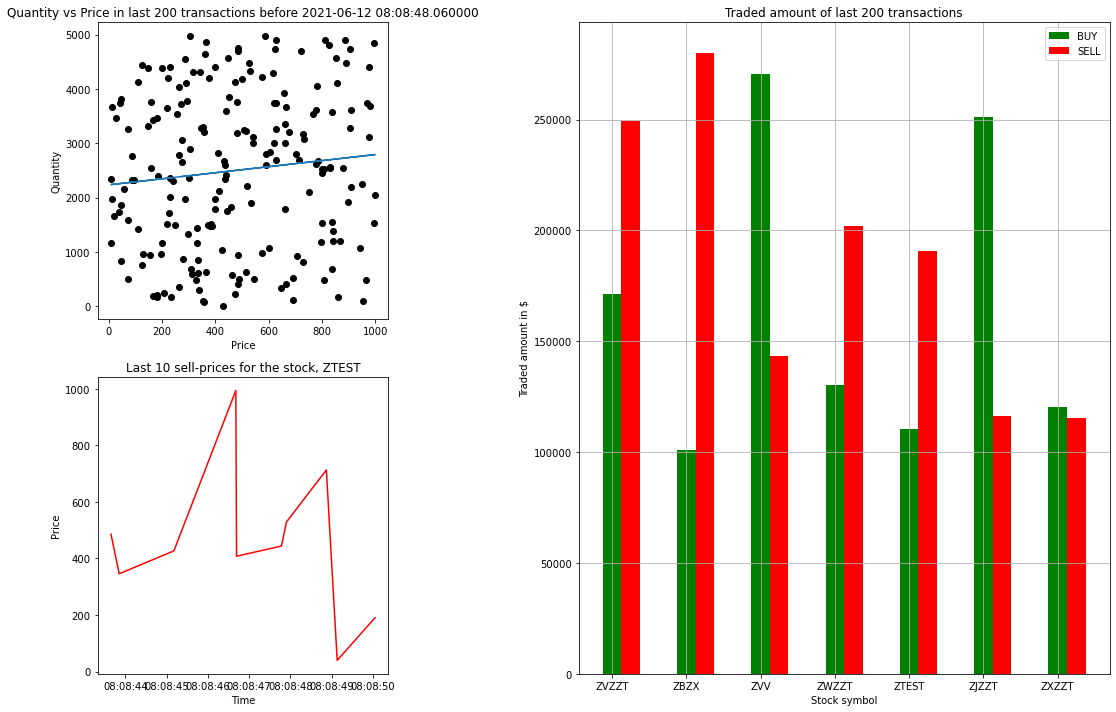

KeyboardInterrupt: 

In [147]:
# combining and updating 3 graphs simultaneously 
stocktrade_stream.stop()


stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()    


while True:
    # aggregating streamed data and displaying in a scatter plot
    # plotting Quantity vs Price
    x_y1 = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 200''')
    x_y1_df = x_y1.toPandas()
    
    if x_y1_df.shape[0] > 0: 
        x1 = x_y1_df.price
        y1 = x_y1_df.quantity
        title1 = f'Quantity vs Price in last 200 transactions before {max(x_y1_df.event_timestamp)}'

    
    # aggregating the streamed data and displaying in a column plot
    # plotting traded amount vs stock (symbol)
    x_y2= spark.sql('''SELECT 
                        symbol
                        , side
                        , sum(price*quantity)/100 as traded_amount_in_dollars
                        , max(event_timestamp) as max_event_timestamp
                    FROM (select * from stocktrade_view order by event_timestamp desc limit 200) as current
                    group by 
                            side
                            , symbol

                   ''')
    x_y2_df = x_y2.toPandas()
    
    labels2 = list(x_y2_df.symbol.unique())

    data2 = [ x_y2_df[x_y2_df['side'] == 'BUY']['traded_amount_in_dollars']
            ,x_y2_df[x_y2_df['side'] == 'SELL']['traded_amount_in_dollars']
           ]
    
    x2 = np.arange(len(x_y2_df.symbol.unique()))
 
    title2 = 'Traded amount of last 200 transactions'
    
    
    # aggregating the streamed data and displaying in a line plot
    x_y3= spark.sql('''SELECT 
                            price
                            , event_timestamp
                            FROM stocktrade_view 
                            where side = 'SELL'
                            and symbol = 'ZTEST'
                            order by event_timestamp desc limit 10
                    ''')
    
    x_y3_df = x_y3.toPandas()
    
    x3 = x_y3_df.event_timestamp
    y3 = x_y3_df.price
    
    title3 = 'Last 10 sell-prices for the stock, ZTEST'
    
    
    print('Preparing streamed data for plots - refreshing every 10 s')
    if (x_y1_df.shape[0] > 0):
        
        bunchofplots(x1, y1, title1, x2, data2, labels2, title2, x3, y3, title3)
    
    
    # updating every 10 s
    time.sleep(10)    

In [ ]:
# Build Spark Query 2 using view "stocktraide_view" - order by timestamp

In [33]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrade_view order by event_timestamp desc').show(15))
time.sleep(1)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZVZZT|stock-trades|2021-06-09 06:21:...| LMN456| ZVZZT| BUY|  978|    1862|User_7|
|    ZTEST|stock-trades|2021-06-09 06:21:...| XYZ789| ZTEST|SELL|  460|    4566|User_6|
|    ZXZZT|stock-trades|2021-06-09 06:21:...| LMN456| ZXZZT|SELL|  545|    1652|User_9|
|     ZBZX|stock-trades|2021-06-09 06:21:...| LMN456|  ZBZX|SELL|  971|    3537|User_3|
|    ZJZZT|stock-trades|2021-06-09 06:21:...| LMN456| ZJZZT|SELL|  295|    4738|User_9|
|    ZWZZT|stock-trades|2021-06-09 06:21:...| ABC123| ZWZZT|SELL|  838|    4270|User_9|
|    ZJZZT|stock-trades|2021-06-09 06:21:...| LMN456| ZJZZT| BUY|  223|    4698|User_1|
|    ZXZZT|stock-trades|2021-06-09 06:21:...| LMN456| ZXZZT|SELL|  264|    2136|User_7|
|    ZJZZT|stock-trades|2021-06-

None

In [69]:
# Export Query 2 to dataframe then parquet file

In [34]:
from pyspark import SparkFiles
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [41]:
df = sqlContext.sql('SELECT * FROM stocktrade_view')
df.count()
# Wait for minutes, run this cell again, ensuring stream more than 13000 rows to the training and testing data.

13068

In [42]:
df_train = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp limit 10000')
df_test = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp desc limit 3000')

In [43]:
df_train.write.parquet('./query2_alldata.parquet',mode='append')

In [ ]:
# Read parquet file for visualisation and machine learning

In [44]:
query2_df = sqlContext.read.parquet('./query_alldata.parquet')
query2_df.show(20)

+---------+------------+--------------------+------+-------+------+----+--------+-----+
|event_key| event_topic|     event_timestamp|userid|account|symbol|side|quantity|price|
+---------+------------+--------------------+------+-------+------+----+--------+-----+
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_5| ABC123| ZVZZT|SELL|    1401|  287|
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_3| LMN456| ZVZZT|SELL|     935|   98|
|     ZBZX|stock-trades|2021-06-06 03:06:...|User_1| LMN456|  ZBZX| BUY|    1795|  306|
|      ZVV|stock-trades|2021-06-06 03:06:...|User_2| LMN456|   ZVV| BUY|    1220|  106|
|    ZJZZT|stock-trades|2021-06-06 03:06:...|User_4| XYZ789| ZJZZT|SELL|     189|  522|
|    ZXZZT|stock-trades|2021-06-06 03:06:...|User_7| ABC123| ZXZZT| BUY|    3060|  545|
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_1| XYZ789| ZVZZT|SELL|    3732|  757|
|      ZVV|stock-trades|2021-06-06 03:06:...|User_8| XYZ789|   ZVV|SELL|    4210|  614|
|    ZWZZT|stock-trades|2021-06-

In [ ]:
# regression model to predict "quantity"

In [45]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [46]:
from pyspark.ml.feature import StringIndexer,VectorAssembler,VectorIndexer
from pyspark.ml.feature import OneHotEncoder

In [47]:
cat_cols = ['userid','account','symbol','side']

In [48]:
stages = []

In [49]:
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol =f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"],outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [50]:
num_cols = ['price']

In [51]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [52]:
assembler = VectorAssembler(inputCols=cat_cols_ohe+num_cols, outputCol="features")

In [53]:
regression = LinearRegression(labelCol='quantity',regParam = 0, maxIter = 10)

In [54]:
stages += [assembler,regression]

In [55]:
print(stages)

[StringIndexer_d4d28e7f56e4, OneHotEncoder_0b81d1dfe278, StringIndexer_23c52b5b3e05, OneHotEncoder_457111890396, StringIndexer_0fbb8fcbb5ea, OneHotEncoder_c8893d0e1642, StringIndexer_7df57323a903, OneHotEncoder_7a93e035824c, VectorAssembler_6bcb078922e2, LinearRegression_a66232e531da]


In [56]:
pipeline = Pipeline(stages=stages)

In [57]:
pipeline = pipeline.fit(query2_df)

In [58]:
train_assessment = pipeline.transform(df_test)

In [59]:
lr_evaluator = RegressionEvaluator(metricName="rmse", labelCol=regression.getLabelCol(), \
                                   predictionCol=regression.getPredictionCol())
RMSE = lr_evaluator.evaluate(train_assessment)
print(RMSE)

1462.4399649714212


In [60]:
train_assessment.show(10)

+---------+------------+--------------------+-------+------+----+-----+--------+------+----------+-------------+-----------+-------------+----------+-------------+--------+-------------+--------------------+------------------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|userid_ind|   userid_ohe|account_ind|  account_ohe|symbol_ind|   symbol_ohe|side_ind|     side_ohe|            features|        prediction|
+---------+------------+--------------------+-------+------+----+-----+--------+------+----------+-------------+-----------+-------------+----------+-------------+--------+-------------+--------------------+------------------+
|    ZXZZT|stock-trades|2021-06-09 06:26:...| LMN456| ZXZZT|SELL|  725|    2931|User_8|       0.0|(8,[0],[1.0])|        1.0|(2,[1],[1.0])|       4.0|(6,[4],[1.0])|     0.0|(1,[0],[1.0])|(18,[0,9,14,16,17...| 2500.946851935326|
|     ZBZX|stock-trades|2021-06-09 06:26:...| XYZ789|  ZBZX| BUY|  512|    3317|User_5|     

In [61]:
train_assessment.count()

3000

In [ ]:
# classification model to predict "side"

In [121]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [146]:
cols_list = ['side','userid','account','symbol','quantity','price']

In [147]:
cat_cols = ['userid','account','symbol']

In [148]:
stages = []
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol =f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"],outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [149]:
target_indexer = StringIndexer(inputCol='side', outputCol='label')

In [150]:
num_cols = ['quantity','price']

In [151]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [152]:
assembler = VectorAssembler(inputCols= cat_cols_ohe + num_cols, outputCol="features")

In [153]:
stages += [target_indexer,assembler]

In [154]:
print(stages)

[StringIndexer_56482db069d5, OneHotEncoder_5cead5c69dcd, StringIndexer_852496767898, OneHotEncoder_ded4e7ba54f6, StringIndexer_62a364d08f21, OneHotEncoder_1a87fa46e484, StringIndexer_c91b597d572b, VectorAssembler_d34dc9176b7a]


In [155]:
pipeline = Pipeline(stages=stages)

In [156]:
pipeline_model = pipeline.fit(query2_df)

In [157]:
df = pipeline_model.transform(query2_df)

In [159]:
df = df.select(['label','features'] + cols_list)
df.show()

+-----+--------------------+----+------+-------+------+--------+-----+
|label|            features|side|userid|account|symbol|quantity|price|
+-----+--------------------+----+------+-------+------+--------+-----+
|  0.0|(18,[6,13,16,17],...|SELL|User_5| ABC123| ZVZZT|    1401|  287|
|  0.0|(18,[1,9,13,16,17...|SELL|User_3| LMN456| ZVZZT|     935|   98|
|  1.0|(18,[4,9,10,16,17...| BUY|User_1| LMN456|  ZBZX|    1795|  306|
|  1.0|(18,[3,9,11,16,17...| BUY|User_2| LMN456|   ZVV|    1220|  106|
|  0.0|(18,[7,8,16,17],[...|SELL|User_4| XYZ789| ZJZZT|     189|  522|
|  1.0|(18,[14,16,17],[1...| BUY|User_7| ABC123| ZXZZT|    3060|  545|
|  0.0|(18,[4,8,13,16,17...|SELL|User_1| XYZ789| ZVZZT|    3732|  757|
|  0.0|(18,[0,8,11,16,17...|SELL|User_8| XYZ789|   ZVV|    4210|  614|
|  1.0|(18,[2,8,12,16,17...| BUY|User_6| XYZ789| ZWZZT|    3501|  315|
|  1.0|(18,[0,8,15,16,17...| BUY|User_8| XYZ789| ZTEST|    1903|   76|
|  1.0|(18,[11,16,17],[1...| BUY|User_7| ABC123|   ZVV|    1969|  820|
|  0.0

In [160]:
train_data,test_data = df.randomSplit([0.8,0.2], seed = 1)

In [161]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

In [166]:
rf_model = rf.fit(train_data)

In [167]:
train_preds = rf_model.transform(train_data)

In [168]:
test_preds = rf_model.transform(test_data)

In [169]:
train_preds.select(cols_list + ['prediction','probability']).show(10)

+----+------+-------+------+--------+-----+----------+--------------------+
|side|userid|account|symbol|quantity|price|prediction|         probability|
+----+------+-------+------+--------+-----+----------+--------------------+
|SELL|User_8| XYZ789|  ZBZX|      52|  746|       1.0|[0.49796200566145...|
|SELL|User_8| XYZ789|  ZBZX|      92|  486|       0.0|[0.50103944388423...|
|SELL|User_8| XYZ789|  ZBZX|     443|  188|       0.0|[0.50623009865165...|
|SELL|User_8| XYZ789|  ZBZX|     511|  332|       0.0|[0.50818578170980...|
|SELL|User_8| XYZ789|  ZBZX|     796|  163|       0.0|[0.50475320487905...|
|SELL|User_8| XYZ789|  ZBZX|     899|  542|       0.0|[0.50477670404205...|
|SELL|User_8| XYZ789|  ZBZX|     959|  513|       0.0|[0.50477670404205...|
|SELL|User_8| XYZ789|  ZBZX|    1138|  484|       0.0|[0.50477670404205...|
|SELL|User_8| XYZ789|  ZBZX|    1182|  921|       0.0|[0.50069622594180...|
|SELL|User_8| XYZ789|  ZBZX|    1251|  252|       0.0|[0.50442970031449...|
+----+------

In [170]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(metricName= 'areaUnderROC')
print(f"[AUROC] train:{evaluator.evaluate(train_preds)} - test: {evaluator.evaluate(test_preds)}")

[AUROC] train:0.5262660807496797 - test: 0.5009496079178354


In [171]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_multi = MulticlassClassificationEvaluator()
acc_metric = {evaluator_multi.metricName: "accuracy"}
print(f"[Accuracy] train:{evaluator_multi.evaluate(train_preds,acc_metric)} - test: {evaluator_multi.evaluate(test_preds, acc_metric)}")

[Accuracy] train:0.5177716865235523 - test: 0.5006371281901919
